In [11]:
import numpy as np
from scipy import stats
from scipy.special import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def calculateExpectedValue(method):
  # Data Preparation
  dist_params = {}

  # Sample dataset
  sample_data = [
      69.7, 60.3, 61.2, 56.4, 52.8, 46.2, 44.7, 44.0, 76.3, 73.4, 94.7, 40.7, 81.1, 65.0,
      64.4, 67.9, 43.9, 35.8, 87.9, 68.5, 64.2, 46.0, 77.0, 53.3, 67.5, 73.0, 167.6, 76.2,
      65.2, 80.2, 47.9, 54.0, 45.4, 96.5, 78.8, 58.4, 56.0, 75.5, 96.3, 54.7, 43.7, 46.4,
      56.8, 50.0, 65.2, 77.0, 83.5, 66.4, 55.0, 43.7
  ]
  n = len(sample_data)

  # Sort sample data for empirical CDF calculation
  sorted_data = np.sort(sample_data)
  # Empirical CDF
  ecdf = np.arange(1, n + 1) / n

  def sse(empirical_cdf, theoretical_cdf):
      return np.sum((empirical_cdf - theoretical_cdf) ** 2)

  def aic(empirical_cdf, theoretical_cdf, k):
      residual = sse(empirical_cdf, theoretical_cdf)
      aic_value = n * np.log(residual / n) + 2 * k
      return aic_value

  def bic(empirical_cdf, theoretical_cdf, k):
      residual = sse(empirical_cdf, theoretical_cdf)
      bic_value = n * np.log(residual / n) + k * np.log(n)
      return bic_value

  def pc(empirical_cdf, theoretical_cdf, k):
      residual = sse(empirical_cdf, theoretical_cdf)
      pc_value = ((n - k) / 2) * np.log(residual / n) + k * (n - 1) / (n - k)
      return pc_value


  def fit_two_param_expon(data):
      mu_estimate = np.min(data)  # Estimate for mu
      shifted_data = data - mu_estimate
      lambda_estimate = 1 / np.mean(shifted_data)  # Estimate for lambda
      return lambda_estimate, mu_estimate

  def two_param_expon_cdf(x, lambda_param, mu_param):
      return 1 - np.exp(-lambda_param * (x - mu_param)) * (x >= mu_param)

  def plot_distributions(data, dist_params, ecdf, ax=None):
      if ax is None:
          fig, ax = plt.subplots(figsize=(10, 6))

      # Plot the empirical CDF
      ax.step(data, ecdf, label='Empirical CDF', where='post')

      x = np.linspace(min(data), max(data), 1000)
      for dist_name, params in dist_params.items():
          if dist_name == "two_expon":
             cdf = two_param_expon_cdf(sorted_data, params[0], params[1])
             ax.plot(x, cdf, label='2-expon CDF')
          else:
            dist = getattr(stats, dist_name)
            cdf = dist.cdf(x, *params[:-2], loc=params[-2], scale=params[-1])
            ax.plot(x, cdf, label=f'{dist_name} CDF')

      ax.legend()
      ax.set_title('Probability Distributions with Empirical CDF')
      ax.set_xlabel('Data values')
      ax.set_ylabel('Probability')

      plt.tight_layout()
      plt.show()

  criteria_values = []
  mean_values = []
  expectedValue = {}
  monteCarloExpected = {}
  # 1-expon, 2-uniform, 3-norm, 4-lognorm, 5-weibull_min, 6-gamma, 7-rayleigh, 8-beta, 9-2expon
  for dist_name in ['expon', 'uniform', 'norm', 'lognorm', 'weibull_min', 'gamma', 'rayleigh', 'beta']:
      dist = getattr(stats, dist_name)
      params = dist.fit(sorted_data, method = method)

      dist_params[dist_name] = params


      theoretical_cdf = dist.cdf(sorted_data, *params[:-2], loc=params[-2], scale=params[-1])
      k = len(params)
      criteria_values.append([
          sse(ecdf, theoretical_cdf),
          sse(ecdf, theoretical_cdf) / n,
          aic(ecdf, theoretical_cdf, k),
          bic(ecdf, theoretical_cdf, k),
          pc(ecdf, theoretical_cdf, k)
      ])
      # Calculate the mean using Monte Carlo simulation
      monteCarloExpected[dist_name] = np.mean(dist.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=10000))



      if dist_name in ['expon', 'norm', 'uniform', 'gamma', 'beta']:
          expected_value = dist.mean(*params[:-2], loc=params[-2], scale=params[-1])
      elif dist_name == 'lognorm':
          expected_value = np.exp(params[-2] + (params[-1]**2) / 2)
      elif dist_name == 'weibull_min':
          c = params[0]
          loc = params[-2]
          scale = params[-1]
          expected_value = loc + scale * gamma(1 + 1/c)
      elif dist_name == 'rayleigh':
          scale = params[-1]
          expected_value = scale * np.sqrt(np.pi/2)
      elif dist_name == 'two_expon':
          loc, scale = params[-2], params[-1]
          expected_value = loc + scale

      expectedValue[dist_name] = expected_value
  lambda_estimate, mu_estimate = fit_two_param_expon(sorted_data)
  theoretical_cdf_custom = two_param_expon_cdf(sorted_data, lambda_estimate, mu_estimate)

  k_custom = 2  # Number of parameters for the two-parameter exponential

  criteria_values.append([
      sse(ecdf, theoretical_cdf_custom),
      sse(ecdf, theoretical_cdf_custom) / n,
      aic(ecdf, theoretical_cdf_custom, k_custom),
      bic(ecdf, theoretical_cdf_custom, k_custom),
      pc(ecdf, theoretical_cdf_custom, k_custom)
  ])

  # Calculate the mean for the custom two-parameter exponential distribution using Monte Carlo simulation
  shifted_data_custom = sorted_data - mu_estimate
  mean_custom = mu_estimate + np.mean(np.random.exponential(1/lambda_estimate, size=10000))


  monteCarloExpected["two_expon"] = mean_custom

  criteria_matrix_updated = np.array(criteria_values)
  plot_distributions(sorted_data, dist_params, ecdf)

  criteria_matrix_updated.shape, criteria_matrix_updated
  return expectedValue, criteria_matrix_updated, monteCarloExpected


In [12]:
distribution_ranks = {
    1:"expon",
    2: "uniform",
    3: "norm",
    4: "lognorm",
    5: "weibull_min",
    6: "gamma",
    7: "rayleigh",
    8: "beta",
    9: "two_expon"
  }

In [13]:
def bestFit(criteria_matrix_updated):


  # New criteria matrix provided by the user
  criteria_matrix_updated = np.array(criteria_matrix_updated)

  # Convert the criteria matrix to a DataFrame for easier manipulation
  criteria_df = pd.DataFrame(criteria_matrix_updated, columns=['SSE', 'MSE', 'AIC', 'BIC', 'PC'])

  # Normalize the criteria (except PC which should be maximized, all others should be minimized)
  # Note: For simplicity, we're just ranking, as higher rank (lower value) is better for SSE, MSE, AIC, and BIC,
  # and lower rank (higher value) is better for PC. This avoids the need for explicit normalization here.
  criteria_df['SSE_rank'] = criteria_df['SSE'].rank()
  criteria_df['MSE_rank'] = criteria_df['MSE'].rank()
  criteria_df['AIC_rank'] = criteria_df['AIC'].rank()
  criteria_df['BIC_rank'] = criteria_df['BIC'].rank()
  criteria_df['PC_rank'] = criteria_df['PC'].rank()

  # Sum the ranks for an overall score, lower is better
  criteria_df['Total_Rank'] = criteria_df[['SSE_rank', 'MSE_rank', 'AIC_rank', 'BIC_rank', 'PC_rank']].sum(axis=1)

  # Sort by total rank to find the best distribution
  criteria_df_sorted = criteria_df.sort_values(by='Total_Rank')

  return criteria_df_sorted

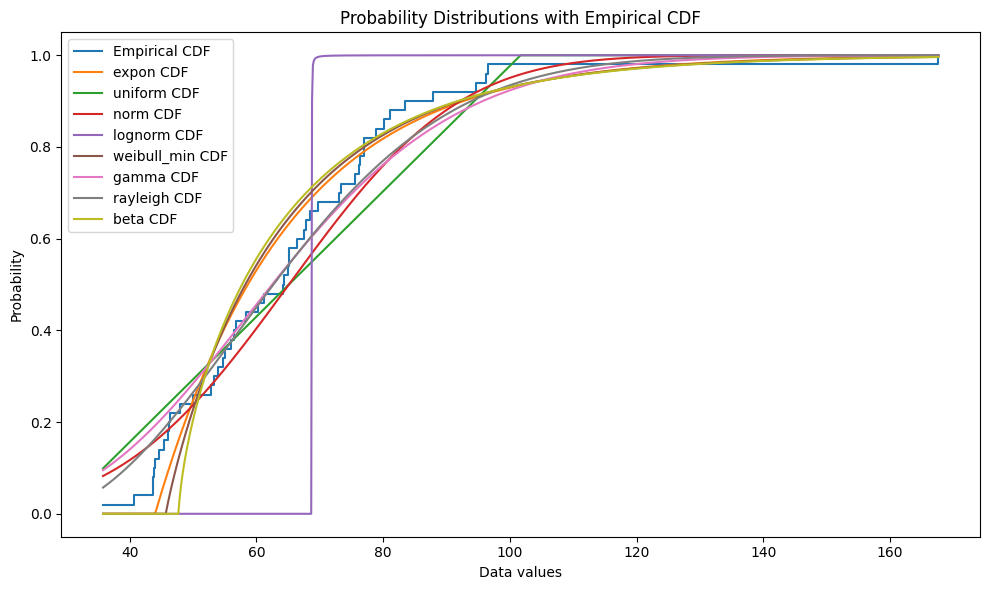

{'expon': 65.12600532691053,
 'uniform': 65.12599869954478,
 'norm': 65.12599999999999,
 'lognorm': 7.282891033452675e+29,
 'weibull_min': 65.12599999999999,
 'gamma': 64.62428029301122,
 'rayleigh': 40.39337145742382,
 'beta': 65.14759239537175}

In [14]:
expectedMM, criteria_matrix_MM, monteCarloExpectedMM = calculateExpectedValue("MM")
expectedMM


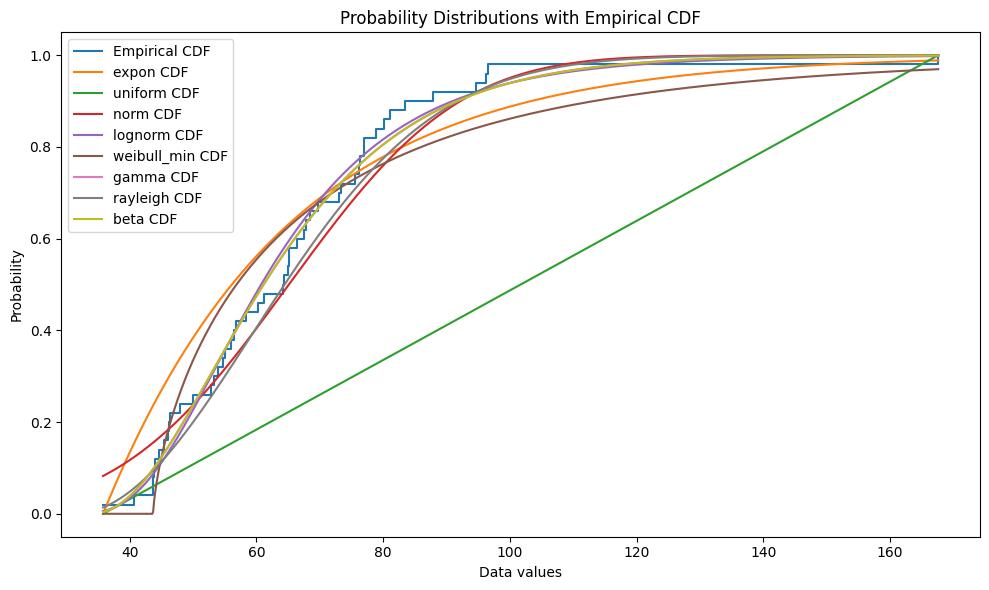

{'expon': 65.12599999999999,
 'uniform': 101.7,
 'norm': 65.12599999999999,
 'lognorm': 1.5093093784637058e+285,
 'weibull_min': 70.62765624188435,
 'gamma': 65.12603613055802,
 'rayleigh': 35.48463288748027,
 'beta': 65.14901832635213}

In [15]:
expectedMLE, criteria_matrix_MLE, monteCarloExpectedMLE = calculateExpectedValue("MLE")
expectedMLE

In [16]:
print("Using MLE")
criteria_MLE_sorted = bestFit(criteria_matrix_MLE)

model_no = criteria_MLE_sorted.iloc[0].name
best_model = distribution_ranks[model_no]
print(f"Best fit model {best_model}")
print(f"Expected Value using Monte Carlo {monteCarloExpectedMLE[best_model]}")
print(f"Expected Value using parameters {expectedMLE[best_model]}")

Using MLE
Best fit model weibull_min
Expected Value using Monte Carlo 70.72775300184956
Expected Value using parameters 70.62765624188435


In [17]:
criteria_MLE_sorted

,SSE,MSE,AIC,BIC,PC,SSE_rank,MSE_rank,AIC_rank,BIC_rank,PC_rank,Total_Rank
5,0.050707,0.001014,-338.685556,-332.949487,-158.874552,1.0,1.0,1.0,1.0,1.0,5.0
7,0.051025,0.001021,-336.372674,-328.724582,-154.150560,2.0,2.0,2.0,2.0,3.0,11.0
3,0.058714,0.001174,-331.354858,-325.618789,-155.429124,3.0,3.0,3.0,3.0,2.0,14.0
6,0.150933,0.003019,-286.147097,-282.323051,-137.228940,4.0,4.0,4.0,4.0,4.0,20.0
2,0.193624,0.003872,-273.693110,-269.869064,-131.251026,5.0,5.0,5.0,5.0,5.0,25.0
4,0.299427,0.005989,-249.895328,-244.159259,-117.143145,6.0,6.0,6.0,6.0,6.0,30.0
8,0.468342,0.009367,-229.528984,-225.704938,-110.052246,7.0,7.0,7.0,7.0,7.0,35.0
0,0.468342,0.009367,-229.528984,-225.704938,-110.052246,8.0,8.0,8.0,8.0,8.0,40.0
1,5.619457,0.112389,-105.289399,-101.465353,-50.417245,9.0,9.0,9.0,9.0,9.0,45.0


In [18]:
print("Using MM")
criteria_MM_sorted = bestFit(criteria_matrix_MM)
model_no = criteria_MM_sorted.iloc[0].name
best_model = distribution_ranks[model_no]

print(f"Best fit model {best_model}")

print(f"Expected Value using Monte Carlo {monteCarloExpectedMM[best_model]}")
print(f"Expected Value using parameters {expectedMM[best_model]}")

Using MM
Best fit model gamma
Expected Value using Monte Carlo 64.76997033579367
Expected Value using parameters 64.62428029301122


In [19]:
criteria_MM_sorted

,SSE,MSE,AIC,BIC,PC,SSE_rank,MSE_rank,AIC_rank,BIC_rank,PC_rank,Total_Rank
6,0.113531,0.002271,-300.385070,-296.561024,-144.063167,1.0,1.0,1.0,1.0,1.0,5.0
5,0.171001,0.003420,-277.905562,-272.169493,-130.307955,2.0,2.0,2.0,2.0,4.0,12.0
2,0.193624,0.003872,-273.693110,-269.869064,-131.251026,3.0,3.0,3.0,3.0,2.0,14.0
0,0.200929,0.004019,-271.841252,-268.017206,-130.362134,4.0,4.0,4.0,4.0,3.0,19.0
4,0.308557,0.006171,-248.393542,-242.657473,-116.437305,5.0,5.0,5.0,5.0,5.0,25.0
1,0.386471,0.007729,-239.136058,-235.312012,-114.663641,6.0,6.0,6.0,6.0,6.0,30.0
7,0.413672,0.008273,-231.735213,-224.087121,-106.017329,7.0,7.0,7.0,8.0,8.0,37.0
8,0.468342,0.009367,-229.528984,-225.704938,-110.052246,8.0,8.0,8.0,7.0,7.0,38.0
3,5.606121,0.112122,-103.408196,-97.672127,-48.294192,9.0,9.0,9.0,9.0,9.0,45.0
